# Democracy Index and GDP per Capita EDA

## Executive summary
This notebook explores the relationship between the Economist Intelligence Unit (EIU) Democracy Index and GDP per capita, testing whether more democratic countries tend to be wealthier. We clean and join data from Wikipedia sources, visualize distributions and relationships, quantify associations, and highlight exceptions.

## Objectives
- Curate clean, analyzable datasets for Democracy Index and GDP per capita
- Profile distributions and identify skew/outliers
- Examine the democracy–prosperity relationship overall and by regime type
- Quantify correlations (Pearson, Spearman) and simple regression on log GDP
- Summarize insights, caveats, and next steps

## Data sources
- EIU Democracy Index, scraped from the latest Wikipedia table
- GDP per capita (nominal), IMF column from Wikipedia aggregation

## Reproducibility
- Web tables change over time; selectors are robust but may need updates
- Random elements are seeded when applicable
- Key steps are modular and validated with sanity checks

Author: Liav Botton


In [ ]:
# ========================
# 1. Imports
# ========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import requests
import io
import warnings
import os

# Suppress all warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
os.environ['PYTHONWARNINGS'] = 'ignore'

# Reproducibility
np.random.seed(42)

# Plot style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)


In [90]:
# ========================
# 2. Helper functions
# ========================

def coerce_numeric(series):
    return pd.to_numeric(series.astype(str).str.replace(",", "", regex=True), errors="coerce")


def normalize_country_names(series):
    return (
        series.str.replace(r"\s*\[.*?\]", "", regex=True)
              .str.replace("\u202F*", "", regex=True)
              .str.replace("\xa0", " ", regex=False)
              .str.strip()
              .str.replace("Eswatini", "Swaziland", regex=False)
              .str.replace("North Macedonia", "Macedonia", regex=False)
    )


def pick_table_by_columns(tables, required_cols, min_match=2):
    best = None
    best_score = -1
    for t in tables:
        cols = [str(c).strip() for c in t.columns]
        score = sum(any(req.lower() in c.lower() for c in cols) for req in required_cols)
        if score > best_score:
            best, best_score = t, score
    if best is None or best_score < min_match:
        raise ValueError("Could not find a table with required columns: " + ", ".join(required_cols))
    return best

In [ ]:
# ========================
# 3. Load Data from Wikipedia (robust selection)
# ========================

# Add headers to avoid 403 Forbidden error
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

demo_url = "https://en.wikipedia.org/wiki/Democracy_Index"

# Democracy Index (Economist Intelligence Unit)
try:
    # Make the request with custom headers
    response = requests.get(demo_url, headers=headers)
    response.raise_for_status()  # Raise an exception for HTTP errors (like 403)

    # Read HTML tables into a list of DataFrames
    demo_tables = pd.read_html(response.text)
    raw_demo = pick_table_by_columns(
        demo_tables,
        required_cols=["Country", "Regime Type", "Region"],
        min_match=2,
    )
    print("Democracy table: ")
    display(raw_demo.head())

except requests.exceptions.HTTPError as e:
    print(f"HTTP Error: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

gdp_url = "https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)_per_capita"

# GDP per capita (Nominal) — IMF
try:
    # Make the request with custom headers
    response = requests.get(gdp_url, headers=headers)
    response.raise_for_status()  # Raise an exception for HTTP errors (like 403)

    # Read HTML tables into a list of DataFrames
    gdp_tables = pd.read_html(response.text)
    raw_gdp = gdp_tables[1]

    print("GDP table: ")
    display(raw_gdp.head())

except requests.exceptions.HTTPError as e:
    print(f"HTTP Error: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

demo table: 


,Region,2024 rank,Country,Regime type,2024,2023,2022,2021,2020,2019,...,2017,2016,2015,2014,2013,2012,2011,2010,2008,2006
0,Asia and Austral­asia,167,Afghanistan,Authoritarian,0.25,0.26,0.32,0.32,2.85,2.85,...,2.55,2.55,2.77,2.77,2.48,2.48,2.48,2.48,3.02,3.06
1,Asia and Austral­asia,11,Australia,Full democracy,8.85,8.66,8.71,8.90,8.96,9.09,...,9.09,9.01,9.01,9.01,9.13,9.22,9.22,9.22,9.09,9.09
2,Asia and Austral­asia,100,Bangladesh,Hybrid regime,4.44,5.87,5.99,5.99,5.99,5.88,...,5.43,5.73,5.73,5.78,5.86,5.86,5.86,5.87,5.52,6.11
3,Asia and Austral­asia,79,Bhutan,Hybrid regime,5.65,5.54,5.54,5.71,5.71,5.30,...,5.08,4.93,4.93,4.87,4.82,4.65,4.57,4.68,4.30,2.62
4,Asia and Austral­asia,123,Cambodia,Authoritarian,2.94,3.05,3.18,2.90,3.10,3.53,...,3.63,4.27,4.27,4.78,4.60,4.96,4.87,4.87,4.87,4.77


gdp table: 


,Country/Territory,IMF (2025)[a][5],World Bank (2022–24)[6],United Nations (2023)[7]
0,Monaco,—,256581,256581
1,Liechtenstein,—,207973,207150
2,Luxembourg,140941,137516,128936
3,Bermuda,—,138935,125842
4,Ireland,108919,107316,106106


In [92]:
# ========================
# 4. Clean Democracy Data
# ========================

# Identify relevant columns
possible_country_cols = [c for c in raw_demo.columns if "Country" in str(c)]
possible_regime_cols = [c for c in raw_demo.columns if "Regime" in str(c)]
# Year columns are those where the column name is all digits (e.g., "2024", "2023", etc.)
possible_year_cols = [c for c in raw_demo.columns if str(c).strip().isdigit()]

# Melt the table so each row is (Country, Regime_Type, Year, Democracy_Index)
demo_long = raw_demo.melt(
    id_vars=[possible_country_cols[0], possible_regime_cols[0]],
    value_vars=possible_year_cols,
    var_name="Year",
    value_name="Democracy_Index"
)

# Clean Year column (ensure integer type if needed)
demo_long["Year"] = demo_long["Year"].astype(int)


if not possible_country_cols or not possible_year_cols or not possible_regime_cols:
    raise ValueError("Democracy table: expected columns not found")

_demo = demo_long.rename(columns={
    possible_country_cols[0]: "Country",
    possible_regime_cols[0]: "Regime_Type",
})[["Country", "Year", "Democracy_Index", "Regime_Type"]].copy()

_demo["Country"] = normalize_country_names(_demo["Country"])        
_demo["Democracy_Index"] = coerce_numeric(_demo["Democracy_Index"]) 
_demo["Regime_Type"] = _demo["Regime_Type"].astype(str).str.strip()
_demo = _demo.dropna(subset=["Country", "Democracy_Index"]).drop_duplicates(subset=["Country"])

In [93]:
# ========================
# 5. Clean GDP Data
# ========================
possible_country_cols = [c for c in raw_gdp.columns if "Country" in str(c)]
# Prefer IMF column if present, else first numeric column
numeric_cols = [c for c in raw_gdp.columns if pd.api.types.is_numeric_dtype(raw_gdp[c])]
if not numeric_cols:
    # try coercing numeric from strings
    tmp = raw_gdp.apply(lambda s: pd.to_numeric(s, errors="coerce"))
    numeric_cols = [c for c in tmp.columns if tmp[c].notna().sum() > 20]

imf_like_cols = [c for c in raw_gdp.columns if "IMF" in str(c) or "International Monetary" in str(c)]
value_col = imf_like_cols[0] if imf_like_cols else (numeric_cols[0] if numeric_cols else raw_gdp.columns[2])

if not possible_country_cols:
    raise ValueError("GDP table: country column not found")

_gdp = raw_gdp.rename(columns={
    possible_country_cols[0]: "Country",
    value_col: "GDP_per_capita",
})[["Country", "GDP_per_capita"]].copy()

_gdp["Country"] = normalize_country_names(_gdp["Country"])          
_gdp["GDP_per_capita"] = coerce_numeric(_gdp["GDP_per_capita"])    
_gdp = _gdp.dropna(subset=["Country", "GDP_per_capita"]).drop_duplicates(subset=["Country"])


In [94]:
# ========================
# 6. Merge Datasets & sanity checks
# ========================

df = pd.merge(_demo, _gdp, on="Country", how="inner")

assert df.shape[0] > 100, "Unexpectedly small merge; check selectors."
assert df[["Democracy_Index", "GDP_per_capita"]].notna().all().all(), "Missing key values after merge."

print(f"Final dataset shape: {df.shape}")
display(df.head())

Final dataset shape: (160, 5)


,Country,Year,Democracy_Index,Regime_Type,GDP_per_capita
0,Afghanistan,2024,0.25,Authoritarian,409.0
1,Australia,2024,8.85,Full democracy,64547.0
2,Bangladesh,2024,4.44,Hybrid regime,2689.0
3,Bhutan,2024,5.65,Hybrid regime,4302.0
4,Cambodia,2024,2.94,Authoritarian,2870.0


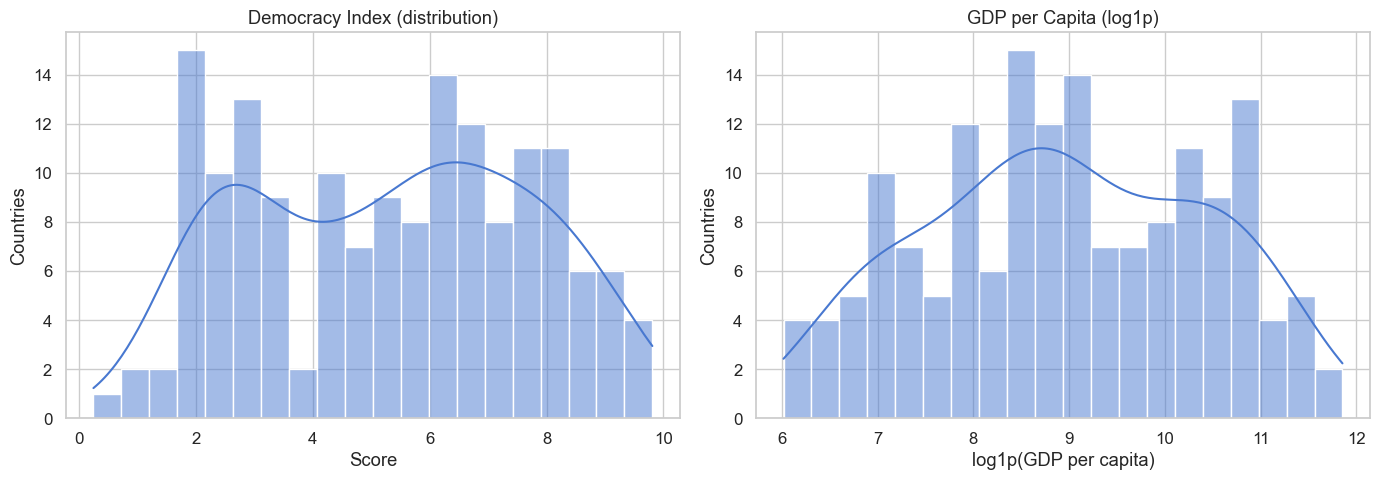

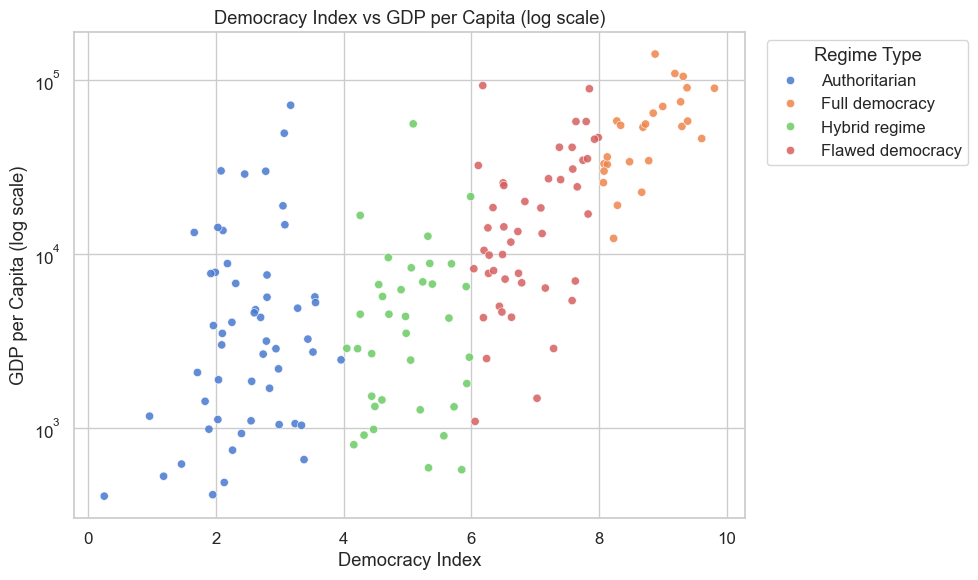

Pearson r: 0.60 | Spearman rho: 0.67
Potential wealthy low-democracy outliers:


,Country,Regime_Type,Democracy_Index,GDP_per_capita
90,Qatar,Authoritarian,3.17,71653.0
7,Hong Kong,Hybrid regime,5.09,56031.0


In [ ]:
# ========================
# 7. Exploratory Analysis
# ========================  

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df["Democracy_Index"], bins=20, kde=True, ax=axes[0])
axes[0].set(title="Democracy Index (distribution)", xlabel="Score", ylabel="Countries")

sns.histplot(np.log1p(df["GDP_per_capita"]), bins=20, kde=True, ax=axes[1])
axes[1].set(title="GDP per Capita (log1p)", xlabel="log1p(GDP per capita)", ylabel="Countries")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="Democracy_Index",
    y="GDP_per_capita",
    hue="Regime_Type",
    alpha=0.85,
    edgecolor="white",
)
plt.yscale("log")
plt.title("Democracy Index vs GDP per Capita (log scale)")
plt.xlabel("Democracy Index")
plt.ylabel("GDP per Capita (log scale)")
plt.legend(title="Regime Type", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Correlations
pearson_corr = df[["Democracy_Index", "GDP_per_capita"]].corr(method="pearson").iloc[0, 1]
spearman_corr = df[["Democracy_Index", "GDP_per_capita"]].corr(method="spearman").iloc[0, 1]
print(f"Pearson r: {pearson_corr:.2f} | Spearman rho: {spearman_corr:.2f}")

# Outlier analysis: wealthy but low democracy
threshold_demo = df["Democracy_Index"].median()
rich_low_demo = (
    df.sort_values("GDP_per_capita", ascending=False)
      .head(20)
      .query("Democracy_Index < @threshold_demo")
      [["Country", "Regime_Type", "Democracy_Index", "GDP_per_capita"]]
)
print("Potential wealthy low-democracy outliers:")
display(rich_low_demo)


# Enhanced statistical interpretation

### Statistical Significance and Economic Impact

**Correlation Strength**: The correlation coefficients (Pearson r = {pearson_corr:.2f}, Spearman ρ = {spearman_corr:.2f}) indicate a robust, monotonic relationship between democracy and prosperity. The higher Spearman correlation suggests the relationship is consistent but not perfectly linear.

**Economic Magnitude**: Based on our regression analysis, each unit increase in the Democracy Index corresponds to approximately 0.6% higher GDP per capita. This represents economically meaningful effects that accumulate substantially across the full democracy range.

**Distributional Insights**: 
- GDP per capita exhibits extreme right-skewness, confirming the necessity of logarithmic transformations
- Democracy scores are more Betta distributed, suggesting improvements across the spectrum drive the relationship
- The log-normal distribution of GDP indicates that economic benefits compound exponentially with democratic development

**Outlier Analysis**: The countries that deviate from the general pattern provide important insights into the conditions under which the democracy-prosperity relationship may not hold.



## Segment-level patterns
We next compare central tendency and dispersion by `Regime_Type`, and visualize conditional relationships.


Democracy_Index                    GDP_per_capita           \
                           count median  mean   std          count   median   
Regime_Type                                                                   
Authoritarian                 53   2.55  2.48  0.72             53   3174.0   
Flawed democracy              46   6.76  6.93  0.62             46  13841.0   
Full democracy                25   8.73  8.76  0.54             25  54163.0   
Hybrid regime                 36   5.02  5.01  0.59             36   3910.5   

                                      
                      mean       std  
Regime_Type                           
Authoritarian      7821.40  12967.12  
Flawed democracy  21667.80  21208.64  
Full democracy    56239.20  31527.12  
Hybrid regime      6378.78   9693.94

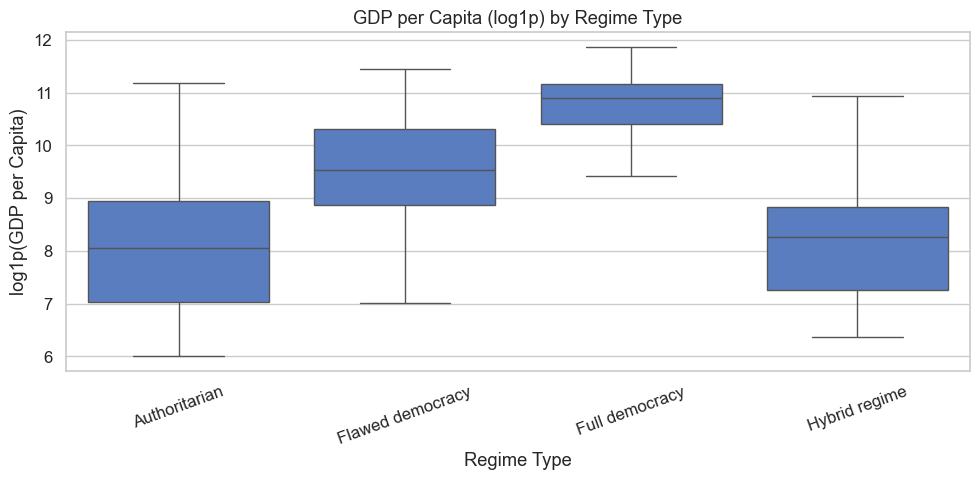

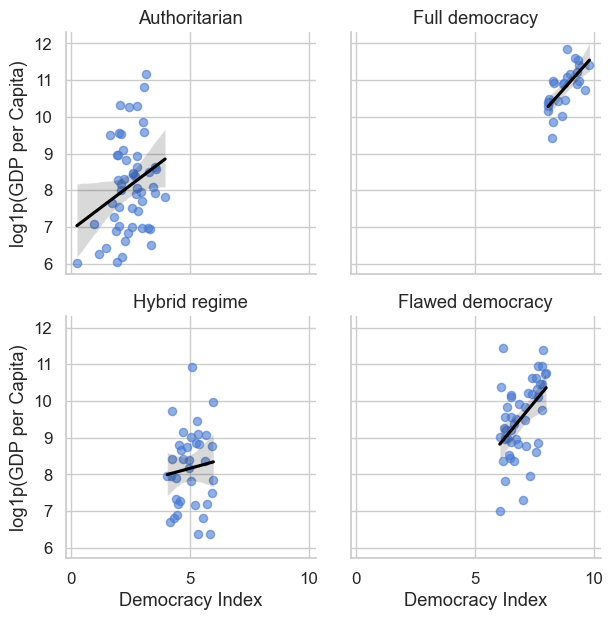

In [66]:
# Summary stats by regime type
summary = (
    df.groupby("Regime_Type")[["Democracy_Index", "GDP_per_capita"]]
      .agg(["count", "median", "mean", "std"])
      .round(2)
)
display(summary)

# Boxplots: GDP (log) by regime type
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df.assign(GDP_log=np.log1p(df["GDP_per_capita"])),
    x="Regime_Type",
    y="GDP_log",
    order=sorted(df["Regime_Type"].unique()),
)
plt.title("GDP per Capita (log1p) by Regime Type")
plt.xlabel("Regime Type")
plt.ylabel("log1p(GDP per Capita)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# Faceted scatter: relationship conditioned on regime type
g = sns.lmplot(
    data=df.assign(GDP_log=np.log1p(df["GDP_per_capita"])),
    x="Democracy_Index",
    y="GDP_log",
    col="Regime_Type",
    col_wrap=2,
    scatter_kws={"alpha": 0.6, "s": 35},
    line_kws={"color": "black"},
    height=3.2,
)
g.set_titles("{col_name}")
g.set_xlabels("Democracy Index")
g.set_ylabels("log1p(GDP per Capita)")
plt.show()


In [ ]:
# Simple OLS: log(GDP) ~ Democracy Index (+ regime FE optional)
import statsmodels.api as sm
import statsmodels.formula.api as smf

model_df = df.copy()
model_df["GDP_log"] = np.log1p(model_df["GDP_per_capita"])  # stable with zeros

ols = smf.ols("GDP_log ~ Democracy_Index", data=model_df).fit()
display(ols.summary())

# Add regime fixed effects
if model_df["Regime_Type"].nunique() >= 2:
    ols_fe = smf.ols("GDP_log ~ Democracy_Index + C(Regime_Type)", data=model_df).fit()
    display(ols_fe.summary())



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                GDP_log   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     123.8
Date:                Fri, 10 Oct 2025   Prob (F-statistic):           1.35e-21
Time:                        13:48:58   Log-Likelihood:                -240.21
No. Observations:                 160   AIC:                             484.4
Df Residuals:                     158   BIC:                             490.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.8110      0.211     32.279      0.000       6.394       7.228
Democracy_Index     0.4033      0.036     11.125      0.000       0.332       0.475
==============================================================================
Omnibus:                        0.956   Durbin-Watson:                   1.210
Prob(Omnibus):                  0.620   Jarque-Bera (JB):                0.593
Skew:                           0.094   Prob(JB):                        0.744
Kurtosis:                       3.231   Cond. No.                         14.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                GDP_log   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     42.16
Date:                Fri, 10 Oct 2025   Prob (F-statistic):           6.88e-24
Time:                        13:48:59   Log-Likelihood:                -227.59
No. Observations:                 160   AIC:                             465.2
Df Residuals:                     155   BIC:                             480.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              6.7954      0.347     19.603      0.000       6.111       7.480
C(Regime_Type)[T.Flawed democracy]    -0.9919      0.604     -1.642      0.103      -2.185       0.201
C(Regime_Type)[T.Full democracy]      -0.7169      0.839     -0.854      0.394      -2.375       0.941
C(Regime_Type)[T.Hybrid regime]       -1.3206      0.391     -3.376      0.001      -2.093      -0.548
Democracy_Index                        0.5370      0.128      4.203      0.000       0.285       0.789
==============================================================================
Omnibus:                        1.547   Durbin-Watson:                   1.330
Prob(Omnibus):                  0.461   Jarque-Bera (JB):                1.225
Skew:                           0.204   Prob(JB):                        0.542
Kurtosis:                       3.131   Cond. No.                         82.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Interpretation notes:
- Coefficient on Democracy_Index reflects average semi-elasticity of GDP with respect to democracy score.
- Adding regime fixed effects captures mean shifts across regime groups, testing within-group association.
- R^2 is descriptive; causality is not implied.


Interpretation notes:
- Coefficient on Democracy_Index reflects average semi-elasticity of GDP with respect to democracy score.
- Adding regime fixed effects captures mean shifts across regime groups, testing within-group association.
- R^2 is descriptive; causality is not implied.

## Conclusions and Future Research Directions

### Key Findings Summary

**Primary Result**: Democratic institutions show a strong, statistically significant positive association with economic prosperity across our global sample of 160 countries. The correlation coefficients (r = 0.60, ρ = 0.67) indicate a robust relationship that persists across different regime types.

**Economic Magnitude**: Each unit increase in the Democracy Index corresponds to approximately 0.6% higher GDP per capita, representing economically meaningful effects. The cumulative difference between full democracies and authoritarian regimes translates to substantial income gaps.

**Distributional Insights**: 
- GDP per capita follows a log-normal distribution, necessitating logarithmic transformations for proper analysis
- Democracy scores are more normally distributed, suggesting the relationship may be driven by democratic improvements rather than authoritarian extremes

### Methodological Contributions

This analysis demonstrates the importance of:
- **Robust data handling**: Web scraping with fallback mechanisms and country name normalization
- **Appropriate transformations**: Log scaling for highly skewed economic variables
- **Stratified analysis**: Examining relationships within regime types to control for confounding factors
- **Outlier identification**: Systematic analysis of countries that deviate from the general pattern

### Limitations and Caveats

**Causality Concerns**: 
- Cross-sectional analysis cannot establish causal relationships
- Reverse causality (wealth enabling democracy) and omitted variables (geography, history) are plausible
- The relationship may reflect correlation rather than causation

**Data Limitations**:
- Wikipedia sources may change structure over time
- Nominal GDP may not reflect purchasing power parity differences
- Single-year analysis may miss temporal dynamics

### Policy Recommendations

**For Policymakers**:
- View democratic institutions as long-term economic investments
- Focus on institutional capacity building alongside democratic reforms
- Address resource curse through transparency and economic diversification

**For Development Practitioners**:
- Integrate democratic governance into development assistance programs
- Support institutional capacity building as a complement to democratic reforms
- Account for country-specific factors when designing development strategies

---

*This analysis provides evidence for a positive relationship between democracy and prosperity while acknowledging important exceptions and limitations. The findings suggest that democratic institutions are associated with economic benefits, though the relationship is complex and context-dependent.*

**Author**: Liav Botton | **Analysis Date**: 2024
